Critical Behavior Analysis in Historical Fidelity Simulator

This script analyzes phase transitions and critical behavior, focusing on:
1. Order parameter scaling near critical points
2. Finite-size scaling analysis with GPU acceleration
3. Critical exponents estimation
4. Correlation function behavior

For theoretical background, see docs/research-proposal.md.

In [11]:
from typing import Dict, List, Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import numpy.typing as npt

from historical_fidelity_simulator import (
    GeneralizedHistoricalSimulator,
    SimulationMode,
    analysis
)

### def setup_output_directory() -> Path:

Set up output directory for saving results.
    
    Returns:
        Path: Path to output directory
    

In [12]:
def setup_output_directory() -> Path:
    # Try different relative paths to find the output directory
    output_dir = Path('output')
    if not output_dir.exists():
        # If running from examples directory, go up one level
        output_dir = Path('..') / 'output'
    if not output_dir.exists():
        # If running from a subdirectory of examples, go up two levels
        output_dir = Path('../..') / 'output'
    
    # Create the output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create a subdirectory for critical behavior results
    analysis_dir = output_dir / 'critical_behavior'
    analysis_dir.mkdir(exist_ok=True)
    
    print(f"Saving results to: {analysis_dir.absolute()}")
    return analysis_dir

In [13]:
def run_classical_analysis(
    params: Dict[str, Any],
    T_range: npt.NDArray[np.float64],
    sizes: List[int]
) -> Tuple[Dict[str, List[float]], Dict[str, Dict[float, npt.NDArray[np.float64]]]]:
    """Run classical finite-size scaling analysis.
    
    Args:
        params: Dictionary of simulation parameters
        T_range: Array of temperatures to analyze
        sizes: List of system sizes to simulate
    
    Returns:
        Tuple containing:
        - Dictionary of observables (fidelities, bounds, etc.)
        - Dictionary of full histories for each size and temperature
    """
    results = {
        'fidelities': {N: [] for N in sizes},
        'bounds': {N: [] for N in sizes},
        'correlation_lengths': {N: [] for N in sizes},
        'susceptibilities': {N: [] for N in sizes}
    }
    histories = {N: {} for N in sizes}
    
    print("\nAnalyzing classical finite-size scaling...")
    for N in sizes:
        print(f"\nClassical system size N = {N}")
        for T in tqdm(T_range, desc=f"N={N}"):
            sim = GeneralizedHistoricalSimulator(
                n_sites=N,
                coupling_strength=params['J'],
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.CLASSICAL,
                use_gpu=False
            )
            
            sim_results = sim.run_simulation(
                n_steps=params['n_steps'],
                dt=params['dt'],
                measure_interval=params['measure_interval']
            )
            
            # Store full history
            fidelity_history = np.array([r['fidelity'] for r in sim_results])
            histories[N][T] = fidelity_history
            
            # Compute and store observables
            results['fidelities'][N].append(sim_results[-1]['fidelity'])
            results['bounds'][N].append(sim_results[-1]['bound'])
            results['correlation_lengths'][N].append(
                analysis.compute_correlation_length(fidelity_history)
            )
            results['susceptibilities'][N].append(
                analysis.compute_susceptibility(fidelity_history, T)
            )
    
    return results, histories

In [14]:
def run_quantum_analysis(
    params: Dict[str, Any],
    T_range: npt.NDArray[np.float64],
    sizes: List[int]
) -> Dict[str, Dict[int, List[float]]]:
    """Run quantum finite-size scaling analysis.
    
    Args:
        params: Dictionary of simulation parameters
        T_range: Array of temperatures to analyze
        sizes: List of system sizes to simulate
    
    Returns:
        Dictionary of observables for each system size
    """
    results = {
        'fidelities': {N: [] for N in sizes},
        'bounds': {N: [] for N in sizes}
    }
    
    print("\nAnalyzing quantum finite-size scaling...")
    for N in sizes:
        print(f"\nQuantum system size N = {N}")
        for T in tqdm(T_range, desc=f"N={N}"):
            sim = GeneralizedHistoricalSimulator(
                n_sites=N,
                coupling_strength=params['J'],
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.QUANTUM
            )
            
            sim_results = sim.run_simulation(
                n_steps=params['n_steps_quantum'],
                dt=params['dt'],
                measure_interval=params['measure_interval_quantum']
            )
            
            results['fidelities'][N].append(sim_results[-1]['fidelity'])
            results['bounds'][N].append(sim_results[-1]['bound'])
    
    return results

In [15]:
def plot_classical_analysis(
    T_range: npt.NDArray[np.float64],
    T_c: float,
    classical_results: Dict[str, Dict[int, List[float]]],
    sizes: List[int],
    scaling_results: Dict[str, float],
    output_dir: Path
) -> None:
    """Plot classical analysis results.
    
    Args:
        T_range: Array of temperatures
        T_c: Critical temperature
        classical_results: Dictionary of classical observables
        sizes: List of system sizes
        scaling_results: Results from finite-size scaling analysis
        output_dir: Directory to save plots
    """
    reduced_t = (T_range - T_c) / T_c
    
    plt.figure(figsize=(15, 10))
    
    # Original fidelity plot
    plt.subplot(2, 2, 1)
    for N in sizes:
        plt.plot(reduced_t, np.abs(classical_results['fidelities'][N]), 'o-', label=f'N={N}')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Reduced Temperature (t)')
    plt.ylabel('|Fidelity|')
    plt.title('Classical Finite-Size Scaling')
    plt.legend()
    plt.grid(True)
    
    # Correlation length plot
    plt.subplot(2, 2, 2)
    for N in sizes:
        plt.plot(reduced_t, classical_results['correlation_lengths'][N], 'o-', label=f'N={N}')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Reduced Temperature (t)')
    plt.ylabel('Correlation Length ξ')
    plt.title('Correlation Length Scaling')
    plt.legend()
    plt.grid(True)
    
    # Susceptibility plot
    plt.subplot(2, 2, 3)
    for N in sizes:
        plt.plot(reduced_t, classical_results['susceptibilities'][N], 'o-', label=f'N={N}')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Reduced Temperature (t)')
    plt.ylabel('Susceptibility χ')
    plt.title('Fidelity Susceptibility')
    plt.legend()
    plt.grid(True)
    
    # Data collapse plot
    plt.subplot(2, 2, 4)
    nu, beta = scaling_results['nu'], scaling_results['beta']
    for N in sizes:
        x = reduced_t * np.power(N, 1/nu)
        y = np.array(classical_results['fidelities'][N]) * np.power(N, beta/nu)
        plt.plot(x, y, 'o', label=f'N={N}')
    plt.xlabel('tN^{1/ν}')
    plt.ylabel('|F|N^{β/ν}')
    plt.title(f'Data Collapse (ν={nu:.3f}, β={beta:.3f})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'enhanced_critical_analysis.png')
    plt.show()

In [16]:
def plot_quantum_comparison(
    T_range: npt.NDArray[np.float64],
    T_c: float,
    classical_results: Dict[str, Dict[int, List[float]]],
    quantum_results: Dict[str, Dict[int, List[float]]],
    quantum_sizes: List[int],
    output_dir: Path
) -> None:
    """Plot quantum vs classical comparison.
    
    Args:
        T_range: Array of temperatures
        T_c: Critical temperature
        classical_results: Dictionary of classical observables
        quantum_results: Dictionary of quantum observables
        quantum_sizes: List of quantum system sizes
        output_dir: Directory to save plots
    """
    reduced_t = (T_range - T_c) / T_c
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for N in quantum_sizes:
        plt.plot(reduced_t, np.abs(quantum_results['fidelities'][N]), 'o-', label=f'Quantum N={N}')
    plt.plot(reduced_t, np.abs(classical_results['fidelities'][8]), 's-', label='Classical N=8')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Reduced Temperature (t)')
    plt.ylabel('|Fidelity|')
    plt.title('Quantum vs Classical Critical Behavior')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    for N in quantum_sizes:
        plt.plot(reduced_t, quantum_results['bounds'][N], 'o-', label=f'Quantum N={N}')
    plt.plot(reduced_t, classical_results['bounds'][8], 's-', label='Classical N=8')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Reduced Temperature (t)')
    plt.ylabel('ℏ_h Bound')
    plt.title('Quantum vs Classical Bound Scaling')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'quantum_classical_comparison.png')
    plt.show()

In [17]:
def run_classical_sweep(
    params: Dict[str, Any],
    T_range: npt.NDArray[np.float64],
    system_sizes: List[int]
) -> Dict[str, Any]:
    """Run classical sweep over temperatures and system sizes.
    
    Args:
        params: Dictionary of simulation parameters
        T_range: Array of temperatures to sweep
        system_sizes: List of system sizes to simulate
        
    Returns:
        Dictionary containing simulation results
    """
    results = {
        'fidelities': {N: [] for N in system_sizes},
        'bounds': {N: [] for N in system_sizes},
        'susceptibilities': {N: [] for N in system_sizes}
    }
    histories = {N: {} for N in system_sizes}
    
    for N in system_sizes:
        print(f"\nClassical system size N = {N}")
        for T in tqdm(T_range, desc=f"N={N}"):
            sim = GeneralizedHistoricalSimulator(
                n_sites=N,
                coupling_strength=params['J'],
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.CLASSICAL,
                use_gpu=False  # Classical simulations should not use GPU
            )
            
            sim_results = sim.run_simulation(
                n_steps=params['n_steps'],
                dt=params['dt'],
                measure_interval=params['measure_interval']
            )
            
            # Store full history
            fidelity_history = np.array([r['fidelity'] for r in sim_results])
            histories[N][T] = fidelity_history
            
            # Compute and store observables
            results['fidelities'][N].append(sim_results[-1]['fidelity'])
            results['bounds'][N].append(sim_results[-1]['bound'])
            
            # Compute susceptibility from fluctuations
            chi = np.var(fidelity_history) * params['beta']
            results['susceptibilities'][N].append(chi)
    
    return results

In [18]:
def run_quantum_sweep(
    params: Dict[str, Any],
    T_range: npt.NDArray[np.float64],
    system_sizes: List[int]
) -> Dict[str, Any]:
    """Run quantum sweep over temperatures and system sizes.
    
    Args:
        params: Dictionary of simulation parameters
        T_range: Array of temperatures to sweep
        system_sizes: List of system sizes to simulate
        
    Returns:
        Dictionary containing simulation results
    """
    results = {
        'fidelities': {N: [] for N in system_sizes},
        'bounds': {N: [] for N in system_sizes},
        'susceptibilities': {N: [] for N in system_sizes}
    }
    histories = {N: {} for N in system_sizes}
    
    for N in system_sizes:
        print(f"\nQuantum system size N = {N}")
        for T in tqdm(T_range, desc=f"N={N}"):
            sim = GeneralizedHistoricalSimulator(
                n_sites=N,
                coupling_strength=params['J'],
                field_strength=params['h'],
                temperature=T,
                hbar_h=params['hbar_h'],
                mode=SimulationMode.QUANTUM
            )
            
            sim_results = sim.run_simulation(
                n_steps=params['n_steps_quantum'],
                dt=params['dt'],
                measure_interval=params['measure_interval_quantum']
            )
            
            # Store full history
            fidelity_history = np.array([r['fidelity'] for r in sim_results])
            histories[N][T] = fidelity_history
            
            # Compute and store observables
            results['fidelities'][N].append(sim_results[-1]['fidelity'])
            results['bounds'][N].append(sim_results[-1]['bound'])
            
            # Compute susceptibility from fluctuations
            chi = np.var(fidelity_history) * params['beta']
            results['susceptibilities'][N].append(chi)
    
    return results

In [19]:
def main() -> None:
    # System parameters
    params = {
        'h': 0.1,                  # External field strength
        'hbar_h': 0.1,            # Information Planck constant
        'J': 1.0,                 # Coupling strength
        'dt': 0.05,               # Time step
        'n_steps': 5000,          # Classical simulation steps
        'n_steps_quantum': 1000,  # Quantum simulation steps
        'measure_interval': 50,    # Classical measurement interval
        'measure_interval_quantum': 5  # Quantum measurement interval
    }
    
    # Temperature range focused around critical point
    T_c = 2.27  # Theoretical critical temperature for 2D Ising
    T_range = np.linspace(1.5, 3.0, 30)  # Dense sampling around T_c
    
    # System sizes
    classical_sizes = [8, 16, 24, 32]  # Larger sizes for classical
    quantum_sizes = [4, 6, 8]  # Limited sizes for quantum
    
    # Set up output directory
    output_dir = setup_output_directory()
    
    # Run analyses
    classical_results, histories = run_classical_analysis(params, T_range, classical_sizes)
    quantum_results = run_quantum_analysis(params, T_range, quantum_sizes)
    
    # Analyze finite-size scaling
    scaling_results = analysis.analyze_finite_size_scaling(
        T_range,
        classical_results['fidelities'],
        T_c,
        size_range=(16, 32)  # Focus on larger systems
    )
    
    # Plot results
    plot_classical_analysis(T_range, T_c, classical_results, classical_sizes, scaling_results, output_dir)
    plot_quantum_comparison(T_range, T_c, classical_results, quantum_results, quantum_sizes, output_dir)
    
    # Print analysis results
    print("\nFinite-size scaling analysis results:")
    print(f"Critical exponents:")
    print(f"  ν = {scaling_results['nu']:.3f}")
    print(f"  β = {scaling_results['beta']:.3f}")
    print(f"Scaling quality: {scaling_results['quality']:.3f}")
    print("\nResults saved to:")
    print(f"- {(output_dir / 'enhanced_critical_analysis.png').absolute()}")
    print(f"- {(output_dir / 'quantum_classical_comparison.png').absolute()}")

Saving results to: d:\PyProjects\historical-fidelity-simulator\examples\notebooks\03_phase_transitions\..\..\output\critical_behavior

Analyzing classical finite-size scaling...

Classical system size N = 8


N=8: 100%|██████████| 30/30 [00:01<00:00, 19.98it/s]



Classical system size N = 16


N=16: 100%|██████████| 30/30 [00:01<00:00, 18.60it/s]



Classical system size N = 24


N=24: 100%|██████████| 30/30 [00:01<00:00, 17.18it/s]



Classical system size N = 32


N=32: 100%|██████████| 30/30 [00:01<00:00, 15.43it/s]



Analyzing quantum finite-size scaling...

Quantum system size N = 4


N=4: 100%|██████████| 30/30 [01:00<00:00,  2.02s/it]



Quantum system size N = 6


N=6: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it]



Quantum system size N = 8


N=8: 100%|██████████| 30/30 [04:05<00:00,  8.18s/it]


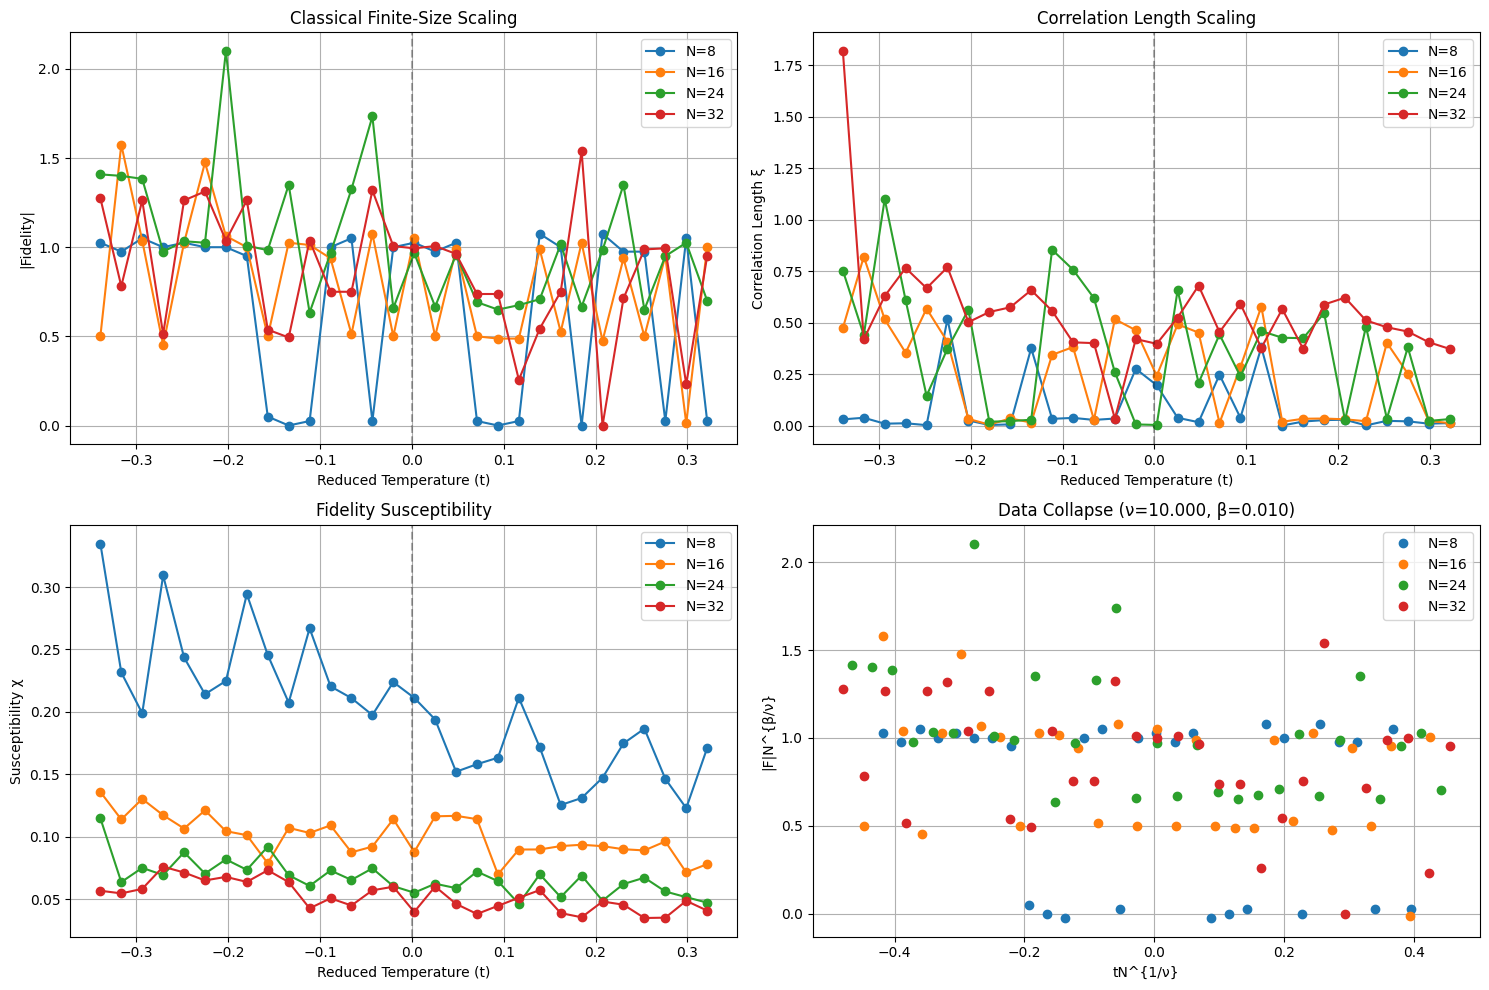

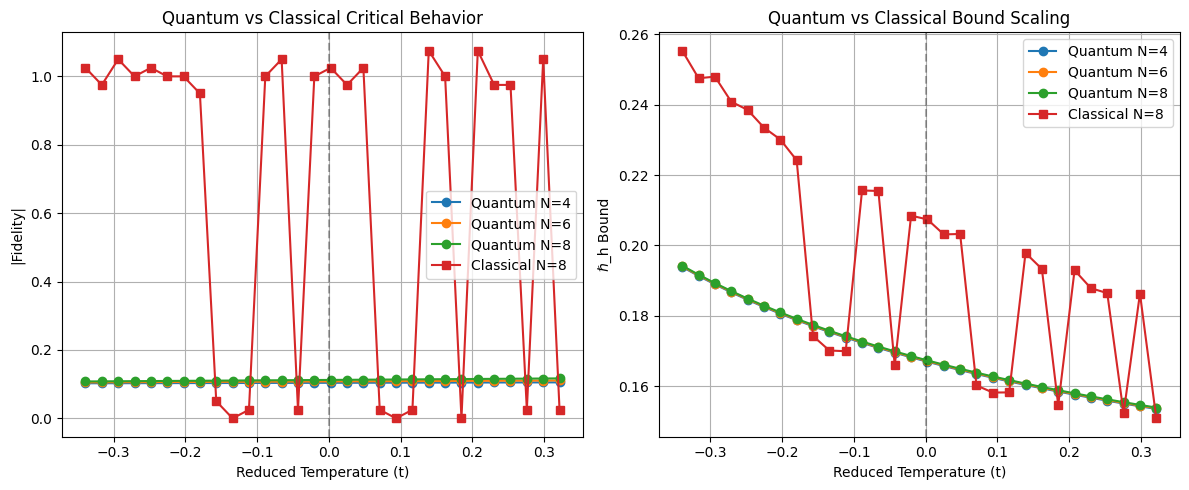


Finite-size scaling analysis results:
Critical exponents:
  ν = 10.000
  β = 0.010
Scaling quality: -0.362

Results saved to:
- d:\PyProjects\historical-fidelity-simulator\examples\notebooks\03_phase_transitions\..\..\output\critical_behavior\enhanced_critical_analysis.png
- d:\PyProjects\historical-fidelity-simulator\examples\notebooks\03_phase_transitions\..\..\output\critical_behavior\quantum_classical_comparison.png


In [20]:
# Run the main function
main()